In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torch import nn, optim
from torch.autograd import Variable as V
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('Is GPU available:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [59]:
# hyperparameters
n_epochs = 10
batchsize = 128
learning_rate = 0.001
use_gpu = torch.cuda.is_available()

In [39]:
# データセットの読み込み、正規化、ミニバッチSGDのためのデータローダーの作成
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = datasets.MNIST(root = './data',
                             train = True,
                             transform = tf,
                             download = True)
mnist_valid = datasets.MNIST(root = './data',
                            train = False,
                            transform = tf)
mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True, num_workers = 4)
mnist_valid_loader = DataLoader(mnist_valid, batch_size = batchsize, shuffle = False, num_workers = 4)
classes = {}
print('train_data:', len(mnist_train))
print('validation_data:', len(mnist_valid))

train_data: 60000
validation_data: 10000


tensor([[0, 6, 8, 2, 1],
        [8, 0, 2, 6, 1],
        [1, 7, 2, 3, 0],
        [8, 8, 3, 3, 7],
        [9, 5, 6, 5, 5]])


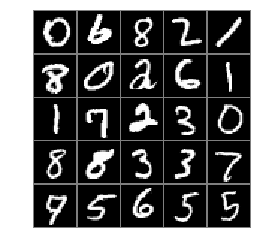

In [40]:
# データの可視化
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
n_show = 25
n_row = 5
images, labels = iter(mnist_train_loader).next()
images, labels = images[:n_show], labels[:n_show]
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(-1, n_row))

In [41]:
# 畳み込みニューラルネットワーク（MNIST用）
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layers2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc = nn.Linear(7 * 7 * 16, 10)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [42]:
# ネットワークを実体化、ロス関数とオプティマイザの定義
net = CNN_MNIST()
if use_gpu:
    net.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# モデルの構造、ロス関数、オプティマイザの表示
print('Model:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

Model:
 CNN_MNIST(
  (layers1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Loss function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [43]:
# 学習を行う関数
def train(train_loader):
    net.train()
    running_loss = 0
    for inputs, targets in train_loader:
        if use_gpu:
            inputs = V(inputs.cuda())
            targets = V(targets.cuda())
        else:
            inputs = V(inputs)
            targets = V(targets)
            
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
    
    train_loss = running_loss / len(train_loader)
    return train_loss

In [44]:
# バリデーションを行う関数
def valid(test_loader):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    for (inputs, targets) in test_loader:
        with torch.no_grad():
            if use_gpu:
                inputs = V(inputs.cuda())
                targets = V(targets.cuda())
            else:
                inputs = V(inputs)
                targets = V(targets)
            
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            
        running_loss += loss.data.item()
        _, preds = torch.max(outputs.data, 1)
        correct += (preds == targets).float().sum()
        total += targets.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [45]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで）
DIRNAME = './mnist_result/'
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(n_epochs):
    loss = train(mnist_train_loader)
    val_loss, val_acc = valid(mnist_valid_loader)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print('epoch[%d/%d], loss:%1.4f val_loss:%1.4f val_acc:%1.4f' % (epoch + 1, n_epochs, loss, val_loss, val_acc))

if not os.path.exists(DIRNAME):
    os.mkdir(DIRNAME)
np.save(DIRNAME + 'loss_list.npy', np.array(loss_list))
np.save(DIRNAME + 'val_loss_list.npy', np.array(val_loss_list))
np.save(DIRNAME + 'val_acc_list.npy', np.array(val_acc_list))
torch.save(net.state_dict(), DIRNAME + 'CNN_MNIST.pth')

epoch[1/10], loss:0.1883 val_loss:0.0560 val_acc:0.9826
epoch[2/10], loss:0.0581 val_loss:0.0527 val_acc:0.9812
epoch[3/10], loss:0.0443 val_loss:0.0390 val_acc:0.9868
epoch[4/10], loss:0.0364 val_loss:0.0331 val_acc:0.9890
epoch[5/10], loss:0.0314 val_loss:0.0358 val_acc:0.9882
epoch[6/10], loss:0.0262 val_loss:0.0311 val_acc:0.9898
epoch[7/10], loss:0.0236 val_loss:0.0327 val_acc:0.9890
epoch[8/10], loss:0.0207 val_loss:0.0294 val_acc:0.9902
epoch[9/10], loss:0.0172 val_loss:0.0312 val_acc:0.9902
epoch[10/10], loss:0.0165 val_loss:0.0288 val_acc:0.9912


In [35]:
# 学習ログの読み込み
loss_list = np.load(DIRNAME + 'loss_list.npy')
val_loss_list = np.load(DIRNAME + 'val_loss_list.npy')
val_acc_list = np.load(DIRNAME + 'val_acc_list.npy')

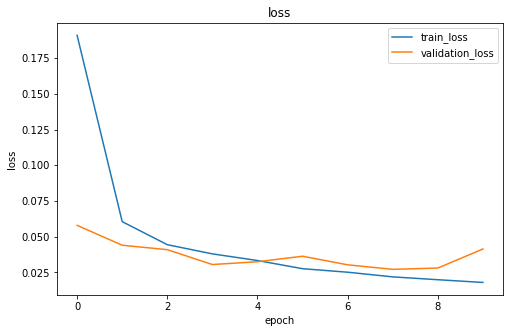

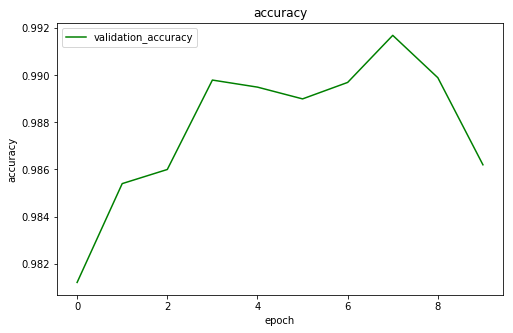

In [36]:
# 学習ログ(lossとaccuracy)の表示
plt.figure(figsize=(8,5))
plt.plot(loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'validation_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_acc_list, 'g-',label='validation_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [37]:
# モデルの重みの読み込み
if use_gpu:
    params = torch.load(DIRNAME + 'CNN_MNIST.pth')
else:
    params = torch.load(DIRNAME + 'CNN_MNIST.pth', map_location = 'cpu')
net = CNN_MNIST()
net.load_state_dict(params)

In [51]:
# 読み込んだ学習済みモデルを使って推論のテスト
# 本当はハイパーパラメータの調整のために用いたvalidationデータは学習において使用されているに等しいので、
# テストデータとして用いるべきではないが、今回は簡単のためひとまず同じものでテスト
mnist_test = datasets.MNIST(root = './data',
                            train = False,
                            transform = tf)
mnist_test_loader = DataLoader(mnist_test, batch_size = len(mnist_test), shuffle = False)
inputs, targets = iter(mnist_test_loader).next()
if use_gpu:
    inputs = inputs.cuda()
outputs = net(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.cpu()
accuracy = (preds == targets).float().sum() / targets.size(0)
print(accuracy)

tensor(0.9912)


tensor([[9, 6, 6, 5, 4],
        [0, 7, 4, 0, 1],
        [3, 1, 3, 4, 7],
        [2, 7, 1, 2, 1],
        [1, 7, 4, 2, 3]])


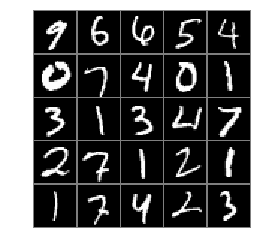

In [58]:
# 推論結果の可視化
s = 20
images, labels = inputs.cpu()[s:s + n_show], preds[s:s + n_show]
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(-1, n_row))